In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

import pickle
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.ticker as mtick

In [2]:
# Specify the location of the weights of the pre-trained baseline model
BASELINE_MODEL = "weights/model_weights_1618972642.h5"

# Load test dataset

In [3]:
from data import load_ckplus
test_generator = load_ckplus("test")

Found 384 images belonging to 8 classes.


# Load baseline model

In [4]:
file = open("weights/model_history_1618972642", "rb")
baseline_history = pickle.load(file)

### Plot training and validation accuracy 

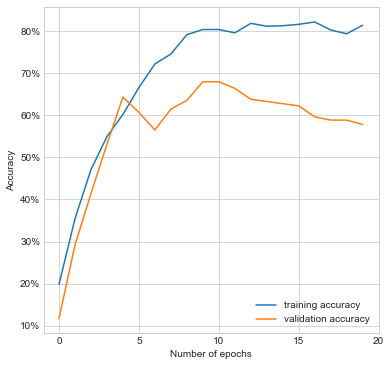

In [5]:
fg = plt.figure(1, (6,6))
ax = fg.add_subplot(1,1,1)

plt.plot(baseline_history["accuracy"], label="training accuracy")
plt.plot(baseline_history["val_accuracy"], label="validation accuracy")
plt.legend(loc="lower right")

plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)

ax.set_xticks(np.arange(0, 21, step=5))

plt.show()

### Plotting training and validation loss 

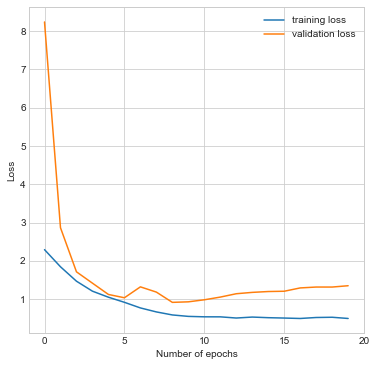

In [6]:
fg = plt.figure(1, (6,6))
ax = fg.add_subplot(1,1,1)

plt.plot(baseline_history["loss"], label="training loss")
plt.plot(baseline_history["val_loss"], label="validation loss")
plt.legend(loc="upper right")

plt.xlabel("Number of epochs")
plt.ylabel("Loss")

ax.set_xticks(np.arange(0, 21, step=5))

plt.show()

### Report baseline model performance

In [7]:
print("Baseline model performance:")
file = open("logs/model_metrics_1618972642", "rb")
baseline_metrics = pickle.load(file)
print("Size:", baseline_metrics["size"])
print("Overall accuracy:", baseline_metrics["acc"])
print("Female accuracy:", baseline_metrics["f_acc"])
print("Male accuracy:", baseline_metrics["m_acc"])

Baseline model performance:
Size: 16512044
Overall accuracy: 0.6796875
Female accuracy: 0.6708333333333333
Male accuracy: 0.6944444444444444


# Auxiliary Functions

In [8]:
def get_samples(method, parameter=None): 
    logs = !ls logs
    if method == "pruning": 
        relevant_logs = list(filter(lambda x: ("pruned_model_metrics_s" + str(parameter)) in x, logs))
    if method == "pruning_and_quantisation": 
        relevant_logs = list(filter(lambda x: ("pruned_and_quantised_model_metrics_s" + str(parameter)) in x, logs))
    elif method == "clustering":
        relevant_logs = list(filter(lambda x: ("clustered_model_metrics_c" + str(parameter)) in x, logs))
    elif method == "clustering_and_quantisation":
        relevant_logs = list(filter(lambda x: ("clustered_and_quantised_model_metrics_c" + str(parameter)) in x, logs))
    elif method == "quantisation": 
        relevant_logs = list(filter(lambda x: x[0] == "q" and "quantised_model_metrics" in x, logs))
        
    all_metrics = []
    for log in relevant_logs: 
        file = open("logs/" + log,'rb')
        all_metrics.append(pickle.load(file))

    samples = {'size': [], 'acc': [], 'f_acc': [], 'm_acc': [], 'f_acc_balanced': [], 'm_acc_balanced': []}
    for metrics in all_metrics: 
        for key in samples: 
            samples[key].append(metrics[key])
                
    return samples

In [9]:
def get_results_for(method, parameter=None): 
    samples = get_samples(method, parameter)

    return {
        "mean": {key: sum(samples[key])/len(samples[key]) for key in samples}, 
        "sd": {key: np.std(samples[key]) for key in samples}
    }

# 1. Quantisation

In [10]:
quant_results = get_results_for("quantisation")

### Size comparison

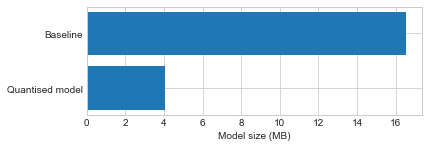

In [11]:
fg = plt.figure(1, (6,2))
ax = fg.add_subplot(1,1,1)

models = ['Baseline', 'Quantised model']
y_pos = np.arange(2)
performance = [baseline_metrics["size"], quant_results["mean"]["size"]]
error = [0, quant_results["sd"]["size"]]

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis() 
ax.set_xlabel('Model size (MB)')

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x // 1000000)
    return s

ax.set_xticks(np.arange(0, 18000000, step=2000000))
yfmt = mtick.FuncFormatter(numfmt)    # create your custom formatter function
ax.xaxis.set_major_formatter(yfmt)

plt.show()

### Accuracy comparison

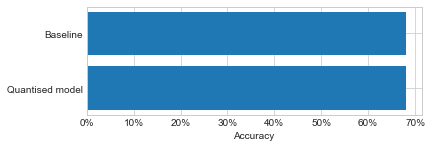

In [12]:
fg = plt.figure(1, (6,2))
ax = fg.add_subplot(1,1,1)

models = ['Baseline', 'Quantised model']
y_pos = np.arange(2)
performance = [baseline_metrics["acc"], quant_results["mean"]["acc"]]
error = [0, quant_results["sd"]["acc"]]

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis() 
ax.set_xlabel('Accuracy')

yticks = mtick.PercentFormatter(1.0)
ax.xaxis.set_major_formatter(yticks)

plt.show()

### Fairness comparison

In [13]:
print("Before quantisation")
print("Female accuracy:", baseline_metrics["f_acc"])
print("Male accuracy:", baseline_metrics["m_acc"])

print("After quantisation")
print("Female accuracy:", quant_results["mean"]["f_acc"], "sd:", quant_results["sd"]["f_acc"])
print("Male accuracy:", quant_results["mean"]["m_acc"], "sd:", quant_results["sd"]["m_acc"])

Before quantisation
Female accuracy: 0.6708333333333333
Male accuracy: 0.6944444444444444
After quantisation
Female accuracy: 0.6708333333333333 sd: 0.0
Male accuracy: 0.6944444444444443 sd: 1.1102230246251565e-16


# 2. Pruning

### Size

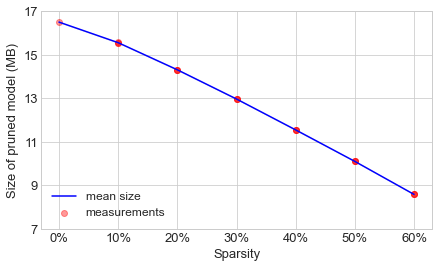

In [14]:
sparsities = [10, 20, 30, 40, 50, 60]
size_points = []

size_means = [get_results_for("pruning", n)["mean"]["size"] for n in sparsities]
size_sds = [get_results_for("pruning", n)["sd"]["size"] for n in sparsities]

for n in sparsities:
    size_points += [(n, size) for size in (get_samples("pruning", n)["size"])]
    
sparsities = [0] + sparsities 
size_means = [baseline_metrics["size"]] + size_means
size_sds = [0] + size_sds
size_points.append((0, baseline_metrics["size"]))

size_means = np.array(size_means)
size_sds = np.array(size_sds)

x, y = list(zip(*size_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(sparsities, size_means, c="blue", label="mean size")
plt.fill_between(sparsities, size_means - size_sds, size_means + size_sds,
                 color='grey', alpha=0.15)
plt.xticks(sparsities, sparsities)
plt.xlabel("Sparsity", size=13)
plt.ylabel("Size of pruned model (MB)", size=13)

plt.legend(loc="lower left", prop={'size': 12})

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x // 1000000)
    return s

yfmt = mtick.FuncFormatter(numfmt)    # create your custom formatter function
ax.yaxis.set_major_formatter(yfmt)
ax.set_yticks(np.arange(7000000, 18000000, step=2000000))

xticks = mtick.PercentFormatter()
ax.xaxis.set_major_formatter(xticks)

plt.show()

### Accuracy

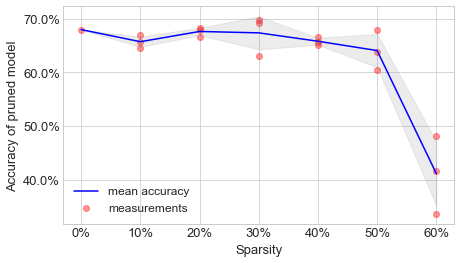

In [15]:
sparsities = [10, 20, 30, 40, 50, 60]
acc_points = []

acc_means = [get_results_for("pruning", n)["mean"]["acc"] for n in sparsities]
acc_sds = [get_results_for("pruning", n)["sd"]["acc"] for n in sparsities]

for n in sparsities:
    acc_points += [(n, size) for size in (get_samples("pruning", n)["acc"])]
    
sparsities = [0] + sparsities 
acc_means = [baseline_metrics["acc"]] + acc_means
acc_sds = [0] + acc_sds
acc_points.append((0, baseline_metrics["acc"]))

acc_means = np.array(acc_means)
acc_sds = np.array(acc_sds)

x, y = list(zip(*acc_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(sparsities, acc_means, c="blue", label="mean accuracy")
plt.fill_between(sparsities, acc_means - acc_sds, acc_means + acc_sds,
                 color='grey', alpha=0.15)
plt.xticks(sparsities, sparsities)
plt.xlabel("Sparsity", size=13)
plt.ylabel("Accuracy of pruned model", size=13)

plt.legend(loc="lower left", prop={'size': 12})

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)

xticks = mtick.PercentFormatter()
ax.xaxis.set_major_formatter(xticks)

plt.show()

### Fairness

In [16]:
results = [["baseline", baseline_metrics["size"], baseline_metrics["acc"], baseline_metrics["f_acc"], baseline_metrics["m_acc"]]] 

sparsities = [10, 20, 30, 40, 50, 60]

for n in sparsities: 
    pr_res = [get_results_for("pruning", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    pr_res = ["pruning @ " + str(n)] + pr_res
    pr_q_res = [get_results_for("pruning_and_quantisation", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    pr_q_res = ["pruning + quantisation @ " + str(n)] + pr_q_res
    
    results.append(pr_res)
    results.append(pr_q_res)

In [17]:
pd.DataFrame(results, columns=["Method", "Model size", "Overall accuracy", "Female accuracy", "Male accuracy"])

,Method,Model size,Overall accuracy,Female accuracy,Male accuracy
0,baseline,1.651204e+07,0.679688,0.670833,0.694444
1,pruning @ 10,1.556572e+07,0.657118,0.598611,0.754630
2,pruning + quantisation @ 10,3.886416e+06,0.654514,0.595833,0.752315
3,pruning @ 20,1.431814e+07,0.676215,0.627778,0.756944
4,pruning + quantisation @ 20,3.737601e+06,0.675347,0.625000,0.759259
5,pruning @ 30,1.297419e+07,0.673611,0.623611,0.756944
6,pruning + quantisation @ 30,3.511213e+06,0.673611,0.623611,0.756944
7,pruning @ 40,1.155352e+07,0.657986,0.634722,0.696759
8,pruning + quantisation @ 40,3.210368e+06,0.660590,0.638889,0.696759
9,pruning @ 50,1.010454e+07,0.640625,0.598611,0.710648


# 3. Clustering

### Model size

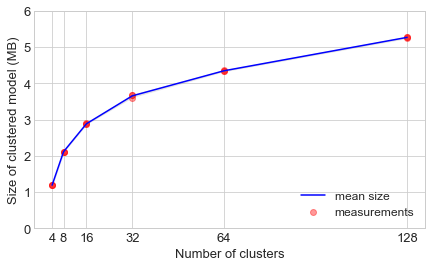

In [18]:
n_clusters = [4, 8, 16, 32, 64, 128]
size_points = []

size_means = np.array([get_results_for("clustering", n)["mean"]["size"] for n in n_clusters])
size_sds = np.array([get_results_for("clustering", n)["sd"]["size"] for n in n_clusters])

for n in n_clusters:
    size_points += [(n, size) for size in (get_samples("clustering", n)["size"])]

x, y = list(zip(*size_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(n_clusters, size_means, c="blue", label="mean size")
plt.fill_between(n_clusters, size_means - size_sds, size_means + size_sds,
                 color='grey', alpha=0.15)
plt.xticks(n_clusters, n_clusters)
plt.xlabel("Number of clusters", size=13)
plt.ylabel("Size of clustered model (MB)", size=13)

plt.legend(loc="lower right", prop={'size': 12})

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x // 1000000)
    return s

yfmt = mtick.FuncFormatter(numfmt)    # create your custom formatter function
ax.yaxis.set_major_formatter(yfmt)
ax.set_yticks(np.arange(0, 7000000, step=1000000))

plt.show()

### Model accuracy

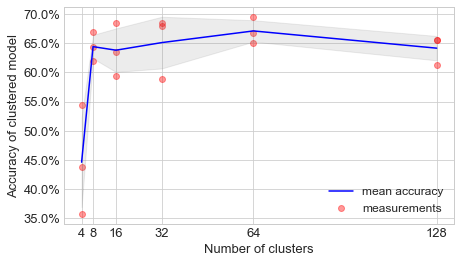

In [19]:
n_clusters = [4, 8, 16, 32, 64, 128]
acc_points = []

acc_means = np.array([get_results_for("clustering", n)["mean"]["acc"] for n in n_clusters])
acc_sds = np.array([get_results_for("clustering", n)["sd"]["acc"] for n in n_clusters])

for n in n_clusters:
    acc_points += [(n, acc) for acc in (get_samples("clustering", n)["acc"])]

x, y = list(zip(*acc_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(n_clusters, acc_means, c="blue", label="mean accuracy")
plt.fill_between(n_clusters, acc_means - acc_sds, acc_means + acc_sds,
                 color='grey', alpha=0.15)
plt.xticks(n_clusters, n_clusters)
plt.xlabel("Number of clusters", size=13)
plt.ylabel("Accuracy of clustered model", size=13)

plt.legend(loc="lower right", prop={'size': 12})

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)
plt.show()

### Fairness

In [20]:
results = [["baseline", baseline_metrics["size"], baseline_metrics["acc"], baseline_metrics["f_acc"], baseline_metrics["m_acc"]]] 

n_clusters = [4, 8, 16, 32, 64, 128]

for n in n_clusters: 
    cl_res = [get_results_for("clustering", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    cl_res = ["clustering @ " + str(n)] + cl_res
    cl_q_res = [get_results_for("clustering_and_quantisation", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    cl_q_res = ["clustering + quantisation @ " + str(n)] + cl_q_res
    
    results.append(cl_res)
    results.append(cl_q_res)

In [21]:
pd.DataFrame(results, columns=["Method", "Model size", "Overall accuracy", "Female accuracy", "Male accuracy"])

,Method,Model size,Overall accuracy,Female accuracy,Male accuracy
0,baseline,1.651204e+07,0.679688,0.670833,0.694444
1,clustering @ 4,1.188872e+06,0.446181,0.430556,0.472222
2,clustering + quantisation @ 4,9.176183e+05,0.435764,0.420833,0.460648
3,clustering @ 8,2.113357e+06,0.644097,0.593056,0.729167
4,clustering + quantisation @ 8,1.811712e+06,0.644965,0.597222,0.724537
5,clustering @ 16,2.885247e+06,0.638021,0.563889,0.761574
6,clustering + quantisation @ 16,2.572676e+06,0.644965,0.570833,0.768519
7,clustering @ 32,3.654835e+06,0.651042,0.605556,0.726852
8,clustering + quantisation @ 32,3.220701e+06,0.657118,0.612500,0.731481
9,clustering @ 64,4.346499e+06,0.671007,0.602778,0.784722
